########################################




Sys.argv had an error! Setting the seed equal to strict!




########################################
Steps: 10
Beginning seed 0.


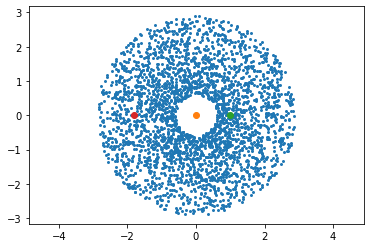

In [8]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


import rebound, numpy as np, matplotlib as mpl
#mpl.use('Agg') # found here:https://stackoverflow.com/questions/4931376/generating-matplotlib-graphs-without-a-running-x-server
import matplotlib.pyplot as plt, time as tiempo, math, sys

sim = rebound.Simulation()
tau = 2*np.pi


# In[3]:


def ttor(R0 = 5e-4): #two to one resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 5**(1/3)*0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=2**(2/3), f=np.pi, r=R0) 
    return sim

def tttr(R0 = 5e-4): #two to three resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=2**(2/3), r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=3**(2/3), f=np.pi, r=R0) 
    return sim

def nor(R0 = 5e-4): #no resonance (initially at least)
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    sim.add(m=1) #creates a star of mass 1
    #R0 = .02
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=1.8, f=np.pi, r=R0) #use .1 mass to show the planets having a large effect on each other
    return sim
    
def resonance_counter(data, base = 1):
    innerplanetcount = 0
    outerplanetcount = 0
    for i, x in enumerate(np.delete(data,len(data)-1,0)):
        if x[0] < 0 and data[i+1][0] > 0:
            innerplanetcount += 1
        if x[1] < 0 and data[i+1][1] > 0:
            outerplanetcount += 1
    R = innerplanetcount/outerplanetcount
    print(R)
    R = R*base
    if R == int(R):
        R = int(R)
    print("The outer planet revolved", outerplanetcount, "times.")
    print("The inner planet revolved", innerplanetcount, "times.")
    print("They are in a {}:{} resonance.".format(base, R))
     
def rand_powerlaw(slope, min_v, max_v): #some distribution functions
    #https://rebound.readthedocs.io/en/latest/ipython/PrimordialEarth.html
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))
def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum
def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

def quickplot(sim): #this uses matplotlib to plot the orbit, instead of rebound
    coords = np.zeros((2,sim.N))
    for i in range(sim.N):
        coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.scatter(coords[0],coords[1],marker=".",linewidth=0)
    for i in range(sim.N_active):
        ax.scatter(sim.particles[i].x,sim.particles[i].y); # Planet
        
def my_merge(sim_pointer, collided_particles_index):
    
    #https://rebound.readthedocs.io/en/latest/ipython/User_Defined_Collision_Resolve.html
    #or
    #https://rebound.readthedocs.io/en/latest/ipython_examples/User_Defined_Collision_Resolve/
    
    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i1 = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.
    j1 = collided_particles_index.p2
    
    if ps[i1]==0 and ps[j1]==0:
        print("both are asteroids")
        return 0
    else:
        if ps[i1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=j1
            l=i1
            destroyi1=True
        if ps[j1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=i1
            l=j1
            destroyi1=False
            
        '''fig, ax = rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
        ax.set_title("Merging particle {} into {}".format(j, i))
        ax.text(ps[k].x, ps[k].y, "1");
        ax.text(ps[l].x, ps[l].y, "2")'''
        # So we plot the scenario exactly at the timestep that the collision function is triggered
        
        #print("merging particle", k,'into particle', l) #use this to know when collisions occur
        
        #particle_mass = Mtot_disk/N_pl
        particle_mass=1e-5
        particle_radius = 1e-5
        # Merging Logic
        total_mass = ps[k].m + particle_mass
        #merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass # conservation of momentum

        # merged radius assuming a uniform density
        merged_radius = (ps[k].r**3 + particle_radius**3)**(1/3)

        #ps[k] = merged_planet   # update p1's state vector (mass and radius will need corrections)
        ps[k].m = total_mass    # update to total mass
        ps[k].r = merged_radius # update to joined radius
        
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1 #after adding mass
        #to a particle, we must recalculate Jacobi coordinates in order to recieve
        #physical values. Note that this code should be commented out if safemode is on.
        
        if destroyi1:
            return 1 #destroys p1, which is the particle w/o mass
        else:
            return 2 #destroys p2, which is the particle w/o mass
     
    
def masslist_txt(masslist,filepath,sim = None, write_type = 'a'):
    """
    Saves the masslists into a formatted txt file.
    """
    
    def avg(lst):
        sum = 0
        for i in lst:
            sum += i
        return sum / len(lst)

    masslistcopy = masslist.copy() # Don't want to edit the original data
    percentlist = list()
    message = ''
    message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        percentlist.append(percentdif)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'   
    message+= "\nAverage percent difference= {}.\n\n".format(avg(percentlist))
    with open(filepath,write_type) as file:
        file.write(sim+'\n')
        file.write(message)

def masslist_txt_append(masslist, filepath,sim = None,write_type = 'a', **kwargs):
    """
    Saves the masslists into a formatted txt file. This is similar to masslist_txt except 
    it lends itself better to appending. It is meant for simulations ran entirely separately.
    """
    
    def avg(listt):
        sum = 0
        for i in listt:
            sum += i
        return sum / len(listt)
    
    masslistcopy = masslist.copy() # Don't want to edit the original data
    message = ''
    import os
    if kwargs.get('first') or not os.path.isfile(filepath): # If file does not exist, create it. If sys.argv[1]==0,
                                                            #then will also create.
        write_type = "w"
        message += sim+'\n'
        message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        #data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'
    with open(filepath,write_type) as file:
        file.write(message)
    if kwargs.get('last') and len(masslist_read(filepath))/4 >= kwargs.get("lastN"):
        with open(filepath, "a") as file:
            file.write("\nAverage percent difference: {}"
                       .format(averagePercent(filepath)))
            file.write("\n"+"#"*40)
# In
def masslist_read(filePath):
    """
    Inverse of masslist_txt()
    """
    with open(filePath,'r') as datafile:
        contents = datafile.read()
    contents = contents.split()
    finalList = []
    for index,value in enumerate(contents):
        try:
            value = float(value)
            finalList.append(value)
            ####contents[index] = value
        except:
            pass
    ####for i in range(0,int(len(contents)), 4):
        ####finalList.append([contents[i:i+4]])
    return finalList
#masslist_read('test.txt')

def avg(listt, **kwargs):
    sum = 0
    length = len(listt)
    if kwargs.get('positive'):
        for i in listt:
            if i > 0:
                sum += i
            else:
                length -= 1
        return sum / length
    if kwargs.get('nonNegative'):
        for i in listt:
            if i >= 0:
                sum += i
            else:
                length -= 1
        return sum / len(listt)
    for i in listt:
        sum += i
    return sum / len(listt)

def averagePercent(filePath):
    dataList = masslist_read(filePath)
    percentList = []
    for i in range(2,len(dataList),4):
        percentList.append(dataList[i])
    return avg(percentList)

# In[4]:

def saveFigs(innerFolder = "", addOn = "", seed = 0, **kwargs):
    """
    This saves several types of graphs into a folder corresponsing to the seed.
    Optional ability to add on to the name of a file easily.
    NOTE: Depending on the stepnumber, some of these graphs may contain useless data,
    because for some data types the stepnumber needs to be very high.
    """
    if kwargs.get("test"):
        seed = "Tests"
    if innerFolder:
        innerFolder += "/"
        import os
        if not os.path.isdir("Figures/"+innerFolder):
            os.mkdir("Figures/"+innerFolder)
        if not os.path.isdir("Figures/"+innerFolder+str(seed)):
            os.mkdir("Figures/"+innerFolder+str(seed))
        if not os.path.isdir("Figures/"+innerFolder+str(seed)+"/Arrays"):
            os.mkdir("Figures/"+innerFolder+str(seed)+"/Arrays")
    
    np.savez("Figures/"+innerFolder+str(seed)+"/graph_data_arrays", times=times, dist=dist, relative_x_value=relative_x_value, relative_y_value=relative_y_value,\
    eccs=eccs, position1=position1, position2=position2, interplanetdistance=interplanetdistance, masses=masses,\
    particleNumber=particleNumber, asteroidAU=asteroidAU, asteroidEccs=asteroidEccs)
    
    plt.clf() # clears any graphs
    quickplot(sim)
    plt.savefig("Figures/"+innerFolder+str(seed)+"/quickplot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim,slices=0.3,color=True)
    plt.savefig("Figures/"+innerFolder+str(seed)+"/reboundPlot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim, slices = .3, color = True, lw = 1, plotparticles = [1,2])
    plt.savefig("Figures/"+innerFolder+str(seed)+"/reboundPlotOnlyPlanets"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, eccs)
    plt.title('Eccentricity Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+innerFolder+str(seed)+"/Eccentricity"+addOn+".pdf")
    np.save("Figures/"+innerFolder+str(seed)+"/Arrays/Eccentricity"+addOn, eccs)
    np.save("Figures/"+innerFolder+str(seed)+"/Arrays/times"+addOn, times)
    
    plt.clf()
    plt.plot(times, relative_x_value)
    plt.title('X Value From Star Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('X Value (AU)')
    plt.savefig("Figures/"+innerFolder+str(seed)+"/relativeXValue"+addOn+".pdf")
    np.save("Figures/"+innerFolder+str(seed)+"/Arrays/relativeXValue"+addOn, relative_x_value)
    
    plt.clf()
    plt.plot(times, masses)
    plt.title('Mass of Planets Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Mass (Solar Masses)')
    plt.savefig("Figures/"+innerFolder+str(seed)+"/masses"+addOn+".pdf")
    np.save("Figures/"+innerFolder+str(seed)+"/Arrays/masses"+addOn, masses)
    
    plt.clf()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Planet Positions')
    axs[0].plot(list(position1[:,0]), list(position1[:,1]),'o')
    axs[1].plot(list(position2[:,0]), list(position2[:,1]),'o')
    axs[0].set_aspect('equal')
    axs[1].set_aspect('equal')
    plt.savefig("Figures/"+innerFolder+str(seed)+"/scatterPlotPositions"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, interplanetdistance)
    plt.title('Interplanetary Distance Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Distance (AU)')
    plt.savefig("Figures/"+innerFolder+str(seed)+"/interplanetaryDistance"+addOn+".pdf")
    np.save("Figures/"+innerFolder+str(seed)+"/Arrays/inderplanetaryDistance"+addOn, interplanetdistance)
    
    plt.clf()
    plt.plot(times, particleNumber)
    plt.title('sim.N over time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('sim.N (AU)')
    plt.savefig("Figures/"+innerFolder+str(seed)+"/particleNumber"+addOn+".pdf")
    np.save("Figures/"+innerFolder+str(seed)+"/Arrays/particleNumber"+addOn, particleNumber)
    
    plt.clf()
    plt.plot(times, asteroidEccs[:,[i for i in range(0,simNi-2-1,50)]], linewidth=1)
    plt.title('Asteroid Eccentricity Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccs')
    plt.savefig("Figures/"+innerFolder+str(seed)+"/RoidEccs"+addOn+".pdf")
    np.save("Figures/"+innerFolder+str(seed)+"/Arrays/asteroidEccs"+addOn, asteroidEccs)
    
    plt.clf()
    plt.plot(times, [avg(EccsList, positive = True) for EccsList in asteroidEccs],linewidth=1)
    plt.title('Asteroid Eccentricity AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+innerFolder+str(seed)+"/RoidEccsAverage"+addOn+".pdf")
    
    plt.clf()
    num_bins = 30
    plt.hist([data for data in asteroidEccs[-1] if data >= 0], num_bins)
    plt.savefig("Figures/"+innerFolder+str(seed)+"/RoidEccsHistoEnd"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, asteroidAU[:,[i for i in range(0,simNi-2-1,50)]], linewidth=1)
    # Does not plot every asteroid
    plt.title('Asteroid Semi Major Axis Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids
    plt.savefig("Figures/"+innerFolder+str(seed)+"/RoidSMAxis"+addOn+".pdf")
    np.save("Figures/"+innerFolder+str(seed)+"/Arrays/asteroidAU"+addOn, asteroidAU)
    
    plt.clf()
    plt.plot(times, [avg(asteroidAUList) for asteroidAUList in asteroidAU],linewidth=1)
    plt.title('Asteroid Semi Major Axis AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.savefig("Figures/"+innerFolder+str(seed)+"/RoidSMAxisAverage"+addOn+".pdf")
    
    plt.clf()
    num_bins =30
    plt.hist([data for data in asteroidAU[0] if data > 0 and data < 5], num_bins)
    plt.savefig("Figures/"+innerFolder+str(seed)+"/RoidSMAxisHistoStart"+addOn+".pdf")
    
    plt.clf()
    plt.hist([data for data in asteroidAU[-1] if data > 0 and data < 5], num_bins)
    plt.savefig("Figures/"+innerFolder+str(seed)+"/RoidSMAxisHistoEnd"+addOn+".pdf")
    
###########################################################################################

def generatettor(simulation = ttor,seed = None, asteroidnumber = 1000):  
    sim = simulation()
    sim.N_active = sim.N

    sim.integrator = "ias15"
    #sim.integrator = "whfast"
    #sim.ri_whfast.corrector = 0 #zero order corrector for better speed
    #sim.ri_whfast.safe_mode = 0 #turns off safemode, *substantial* speed boost
    #sim.dt = 0.001*2*np.pi #mutiple by 2pi if in units such that G=1
    sim.testparticle_type = 0
    #sim.ri_ias15.min_dt = 1e-6 # ensure that close encounters do not stall the integration

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = my_merge
    sim.collision_resolve_keep_sorted = 1
    sim.boundary = "open"
    boxsize = 100
    sim.configure_box(boxsize)
    sim.track_energy_offset = 1

    N_pl = asteroidnumber                # Number of planetesimals
    Mtot_disk = 10*sim.particles[1].m    # Total mass of planetesimal disk
    m_pl = 0 #Mtot_disk / float(N_pl)    # Mass of each planetesimal
    r_pl = 2e-9 

    #seed = 0
    auList = np.linspace(.6,2.2,asteroidnumber) # use this to NOT randomize the starting distance
    index = 0
    if not seed == 'strict':
        np.random.seed(seed) # by setting a seed we will reproduce the same simulation every time
    else:
        np.random.seed(0)
    while sim.N < (N_pl + sim.N_active):
        #a = rand_powerlaw(0, 0.1, 3) 
        a = rand_uniform(.6,2.9)
        if seed == 'strict':
            a = auList[index]
        #e = rand_rayleigh(0.01) by default is 0
        e=0
        #inc = rand_rayleigh(0.005)
        inc=0
        f = rand_uniform(-np.pi,np.pi)
        p = rebound.Particle(simulation=sim,primary=sim.particles[0], r=r_pl, a=a, f=f)
        # Only add planetesimal if it's far away from the planet
        d1 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[1].xyz))
        d2 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[2].xyz))
        d = min(d1,d2)
        if d>5e-4:
            sim.add(p)
            index += 1

    # Hash Creation
    ps = sim.particles
    ps[0].hash = "star"
    ps[1].hash = "innerPlanet"
    ps[2].hash = "outerPlanet"
    for i in range(3,sim.N): # this sets their hash to their starting particle number
        ps[i].hash = str(i)

    sim.collision_resolve = my_merge

    #sim.move_to_com()
    E0 = sim.calculate_energy()
    #quickplot(sim)
    return sim
    
def quickcollect2(n, Ti, Tf, stepnumber, **kwargs): #collects orbital data on the first two bodies in a system
    initialtime = tiempo.monotonic()
#     n=2 #number of planets
#     T=80*2*np.pi #years of simulation
    # Planet variables
    global times, dist, relative_x_value,relative_y_value, eccs, position1, position2, \
    interplanetdistance, masses, particleNumber
    times = np.linspace(Ti,Tf,stepnumber)
    #diftimes = list()
    dist = np.zeros((len(times),n)) 
    relative_x_value = np.zeros((len(times),n))
    relative_y_value = np.zeros((len(times),n))
    eccs = np.zeros((len(times),n))
    position1 = np.zeros((len(times),2))
    position2 = np.zeros((len(times),2))
    interplanetdistance = np.zeros((len(times),1))
    particleNumber = np.zeros((len(times),1))
    masses = np.zeros((len(times),n))
    ps = sim.particles
    # Asteroid variables:
    global asteroidAU, asteroidEccs, simNi
    simNi = sim.N
    asteroidAU = np.zeros((len(times),simNi-n-1)) # n is the number of planets, 1 is the number of stars
    asteroidEccs = np.negative(np.ones((len(times),simNi-n-1)))
    #
    print(f"Total steps: {stepnumber}")
    print("| {} time = {} years | {} particles | {} step number |\n| {} second | {} minutes.\n"\
    .format(0,0/tau,sim.N,0,round((tiempo.monotonic()-initialtime),1)\
    ,round((tiempo.monotonic()-initialtime)/60,1)))
    #
    for i, t in enumerate(times):
        sim.integrate(t)
        print("| {} time = {} years | {} particles | {} step number |\n\
| {} second | {} minutes | {} hours.\n"\
        .format(t,t/tau,sim.N,i,round((tiempo.monotonic()-initialtime),1)\
        ,round((tiempo.monotonic()-initialtime)/60,1),round((tiempo.monotonic()-initialtime)/3600,1)))
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1
        #sim.integrator_synchronize()
        #diftimes.append(sim.t+dT)
        #if i== int(stepnumber/2):
            #print("1/2 done at {} seconds.".format(int(tiempo.time() - initialtime)))
        ps = sim.particles
        interplanetdistance[i] = np.linalg.norm(np.array(ps[2].xyz)-np.array(ps[1].xyz))
        particleNumber[i] = sim.N
        position1[i] = [ps[1].x,ps[1].y]
        position2[i] = [ps[2].x,ps[2].y]
        for planet in range(n):
            planetdif = planet+1
            dist[i,planet] = np.linalg.norm(np.array(ps[planetdif].xyz)-np.array(ps[0].xyz))
            relative_x_value[i,planet] = ps[planetdif].x - ps[0].x
            relative_y_value[i,planet] = ps[planetdif].y - ps[0].y
            eccs[i,planet] = ps[planetdif].e
            masses[i,planet] = ps[planetdif].m
        position1[i] = [relative_x_value[i,0],relative_y_value[i,0]]
        position2[i] = [relative_x_value[i,1],relative_y_value[i,1]]
        #### Data collection from asteroids:
        if kwargs.get("asteroidCollect"):
            for roidNumber in range(3,simNi):
                #print("index:{}, roidNumber: {}".format(index,roidNumber))
                index = roidNumber - n -1
                try:                    
                    asteroidAU[i,index] = ps[str(roidNumber)].a
                    asteroidEccs[i,index] = ps[str(roidNumber)].e
                except rebound.ParticleNotFound:
                    pass
        ####
    finaltime = tiempo.monotonic()
#     print('done')
    #print("{} done at {} seconds!".format((a+1)/10,int(finaltime-initialtime)))
    print("Done at {} seconds!".format((int(finaltime-initialtime))))
#     print("The inner planet ended with a mass of {}.".format(ps[1].m))
#     print("The outer planet ended with a mass of {}.".format(ps[2].m))
#     print("There are {} particles remaining.".format(sim.N))
    #
    print("| {} time = {} years | {} particles | {} step number |\n| {} second | {} minutes | {} hours.\n"\
    .format(sim.t,sim.t/tau,sim.N,stepnumber,round((tiempo.monotonic()-initialtime),1)\
    ,round((tiempo.monotonic()-initialtime)/60,1), round((tiempo.monotonic()-initialtime)/3600,1)))
    #
    quickplot(sim)
    #ding()
    
def remove(AU, sim = sim):
    for i in reversed(range(sim.N)):
        ps = sim.particles
        if np.linalg.norm(np.array(ps[i].xyz)-np.array(ps[0].xyz)) > AU:
            sim.remove(i)

# In[20]:

##################################################################################
def batchInfo(*args, **kwargs):
    """
    General info relevant to these batch jobs:
    """
    timesDict = {"seed":"max/min time needed",0:"4h18m",1:"min:9h",2:"time:3h4m",
    3:"time:5h4m",4:"time:3h18m",5:"3h42m",6:"4h30m",7:"4h8m,min:9h",8:"time:4h23m",9:"time:4h32m"}
##################################################################################
#numberOfSims = 1
endTime = 1 #years of simulation
ttor_masses = [['inner planet mass', 'outer planet mass','seed']]
BIGinitial = tiempo.monotonic()
#
#for a in range(numberOfSims):
try:
    a = int(sys.argv[1])
except ValueError:
    print("#"*40)
    print("\n"*3)
    print("Sys.argv had an error! Setting the seed equal to strict!")
    print("\n"*3)
    print("#"*40)
    a = 0
stepFrequency = .1 # how often should a step occur (years)
steps = int(endTime/stepFrequency) # Will round down to an integer
print(f"Steps: {steps}")
print("Beginning seed {}.".format(a))
sim = generatettor(simulation = nor, seed =a, asteroidnumber = 3000)
quickplot(sim)
# #plt.hist([sim.particles[i].a for i in range(3,2003)],100)
# plt.show()
# quickcollect2(n=2, Ti = 0 * tau, Tf=endTime * tau, stepnumber = steps, asteroidCollect = True) # Can override 'steps' by setting a value directly
# ps = sim.particles
# print("Masses {} and {}.".format(ps[1].m,ps[2].m))
# print("Ending seed {}.\n".format(a))
# pre_list = [ps[1].m, ps[2].m,a]
# ttor_masses.append(pre_list)
# BIGfinal = tiempo.monotonic()
# #
# totaltime = BIGfinal - BIGinitial
# print("That in total took {} seconds ({} minutes, {} hours).".format(int(totaltime), round(totaltime/60,2), round(totaltime/3600,2)))
# # try:
# #     sysarg2 = int(sys.argv[2])
# # except IndexError: # if sys.argv[2] does not exist, it is a middle data point
# #     sysarg2 = -1
# # except ValueError:
# #     print("#"*40+"\nsys.argv[2] is a string. It is likely the filepath.\n"+"#"*40)
# #     raise ValueError # I do not want the code to still run
# lastN = 2
# # if int(sysarg2)>0: #sys.argv[2]>0 could be last data point
# #     first = False
# #     last = True
# #     lastN = sysarg2
# # elif int(sysarg2)==-1: #middle data points
# #     first = False
# #     last = False
# # elif int(sysarg2)==0:  # sys.argv[2]==0 will mean this is the first data point, 
# #     first = True
# #     last = False
# first=False
# last=True


# masslist_txt_append(ttor_masses,'Masslists/2000July19TEST.txt','ttor','a', first = first, last = last, lastN = lastN)
# print(ttor_masses)
# print("There are {} particles remaining.".format(sim.N))

# saveFigs(innerFolder= "2000asteroidsTEST",seed = a) # the folder witin the figures folder is set with the seed kwarg. Setting seed = "Tests" will
#                    # put the figures in the Tests folder (still within Figures)
# # np.savez("Figures/"+innerFolder+"graph_data_arrays", times=times, dist=dist, relative_x_value=relative_x_value, relative_y_value=relative_y_value,\
# #     eccs=eccs, position1=position1, position2=position2, interplanetdistance=interplanetdistance, masses=masses,\
# #     particleNumber=particleNumber, asteroidAU=asteroidAU, asteroidEccs=asteroidEccs)



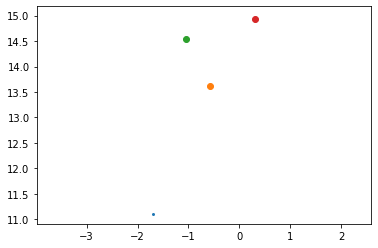

In [6]:
quickplot(sim)

In [7]:
sim.particles[0]

<rebound.particle.Particle object at 0x7f9802080950, m=1.0 x=-0.5750406965013769 y=13.625158939861556 z=0.0 vx=0.0015436593194370594 vy=0.000248225023891395 vz=0.0>

In [3]:
E0

-0.0008154272402872635

In [2]:
sim.calculate_energy()

-0.0024516365924350456

In [4]:
asteroidEccs[-1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00977469, 0.        , 0.65833077, 0.        , 0.        ,
       0.0064416 , 0.04107512, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00419709, 0.        , 0.        , 0.0170474 , 0.        ,
       0.        , 0.93294643, 0.        , 0.        , 0.28810865,
       0.05186572, 0.        , 0.00346148, 0.        , 0.00887923,
       0.        , 0.        , 0.78410993, 0.        , 0.01080975,
       0.        , 0.        , 0.        , 0.        , 0.00350519,
       0.6344439 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00508045, 0.        ,
       0.        , 0.0032816 , 0.        , 0.        , 0.        ,
       0.        , 0.82354522, 0.18097479, 0.        , 0.        ,
       0.        , 0.61340977, 0.        , 0.        , 0.     

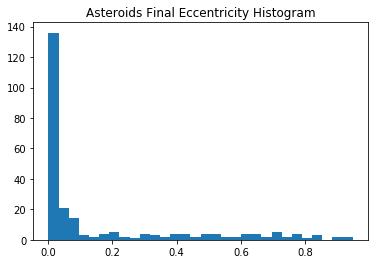

In [7]:
    plt.clf()
    num_bins = 30
    plt.hist([data for data in asteroidEccs[-1] if data > 0], num_bins)
    plt.title("Asteroids Final Eccentricity Histogram")
    plt.savefig("Figures/"+str(15)+"/RoidEccsHistoEnd"+''+".pdf")

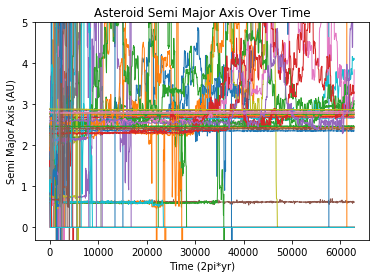

In [9]:
    plt.clf()
    plt.plot(times, asteroidAU[:,[i for i in range(0,simNi-2-1,10)]], linewidth=1)
    # Does not plot every asteroid
    plt.title('Asteroid Semi Major Axis Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids
    plt.savefig("Figures/"+str(15)+"/RoidSMAxis"+"test1"+".pdf")

In [18]:
    plt.clf()
    plt.plot(times, [avg(asteroidAUList,positive=True) for asteroidAUList in asteroidAU],linewidth=1)
    plt.title('Asteroid Semi Major Axis AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')

ZeroDivisionError: division by zero

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

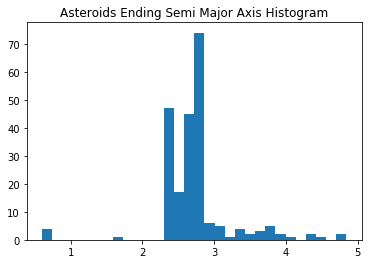

In [16]:
saveFigs(addOn = "", seed = 15)

In [30]:
int("seed")

ValueError: invalid literal for int() with base 10: 'seed'

In [7]:
innerRad, outerRad = .4,4
print(innerRad)

0.4


In [18]:
rand_uniform(2,5)

4.552876722988957

In [19]:
stuff = np.load("Figures/0/Arrays/asteroidAU.npy")

In [22]:
max(stuff[0])

2.894064652628665